# Hi :)

----

# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initialization

In [2]:
# Physical parameters
m= 0.1    # pendulum mass (kg)
M= 5.0    # cart mass (kg)
g= 9.81   # gravity (m/s^2)
l= 0.72   # pendulum length (m)
dt= 0.001 # sampling time (s) = 1ms

# Continuous-time dynamics
def pendulum_dynamics(x, u):
    x1, x2, x3, x4= x

    dx1= x2

    num2= u * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * np.cos(x1) * np.sin(x1) * x2**2
    den2= m * l * np.cos(x1)**2 - (M + m) * l
    dx2= num2 / den2

    dx3= x4

    num4= u + m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1)
    den4= M + m - m * np.cos(x1)**2
    dx4= num4 / den4

    return np.array([dx1, dx2, dx3, dx4])

# Discretization

In [3]:
# Discretization using Euler integration
def discrete_step(x, u, dt):
    dx= pendulum_dynamics(x, u)
    return x + dt * dx

In [4]:
# Initial state and zero input
x0= np.array([0.0, 0.0, 0.0, 0.0])
u= 0.0

In [5]:
# Simulate for 100 steps
x= x0
states= [x0]
for _ in range(100):
    x= discrete_step(x, u, dt)
    states.append(x)

states= np.array(states)

Visualization

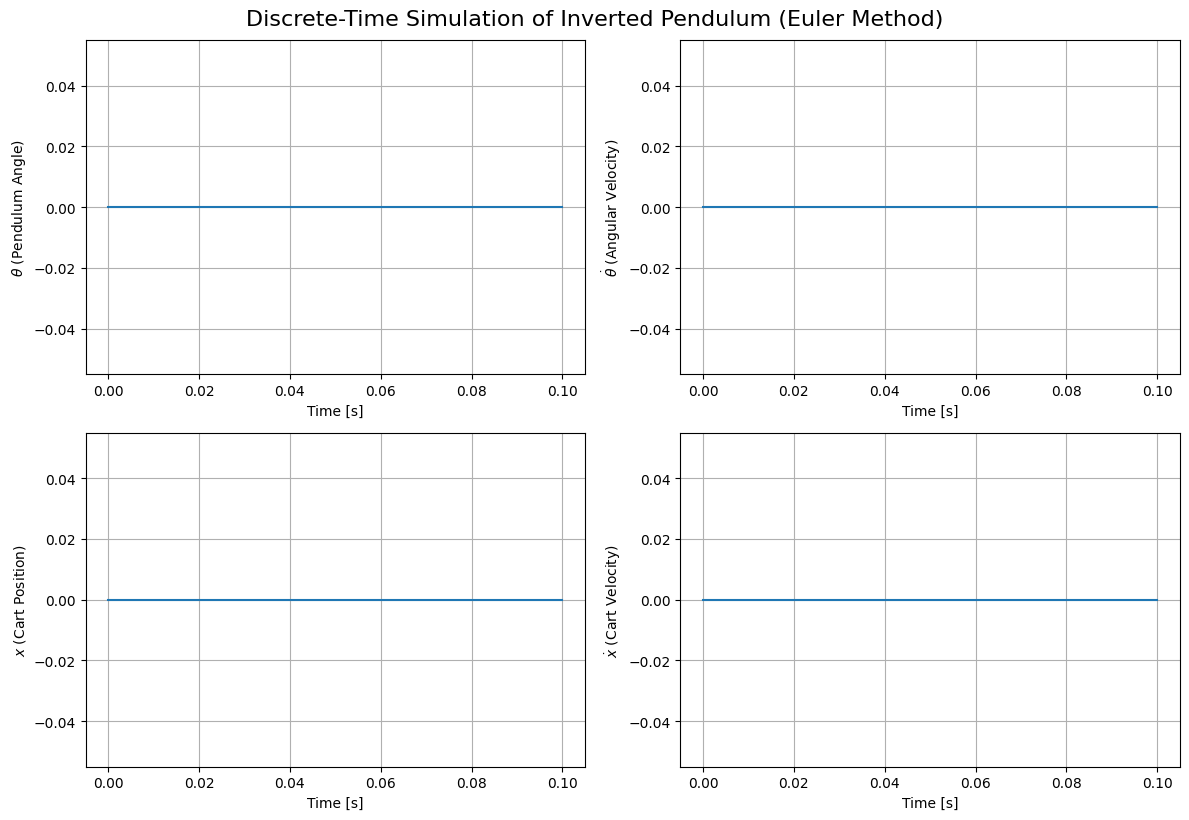

In [6]:
# Time vector
time= np.arange(states.shape[0]) * dt

# Plotting
plt.figure(figsize=(12, 8))

labels= [r'$\theta$ (Pendulum Angle)', 
          r'$\dot{\theta}$ (Angular Velocity)', 
          r'$x$ (Cart Position)', 
          r'$\dot{x}$ (Cart Velocity)']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, states[ : , i])
    plt.xlabel('Time [s]')
    plt.ylabel(labels[i])
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Discrete-Time Simulation of Inverted Pendulum (Euler Method)', fontsize= 16, y= 1.02)
plt.show()